In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/uware/rosbags/_2022-02-23-16-13-20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,10,30,45,60,75]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,-39.974795
1,0.113535,-33.068873
2,0.243042,-31.489528
3,0.367034,-21.946535
4,0.500799,-13.647088
...,...,...
1550,81.704319,73.232091
1551,81.759797,73.409454
1552,81.808066,73.362492
1553,81.857710,73.266277


<AxesSubplot:xlabel='relative_time'>

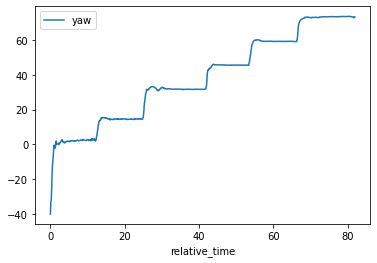

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

361

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

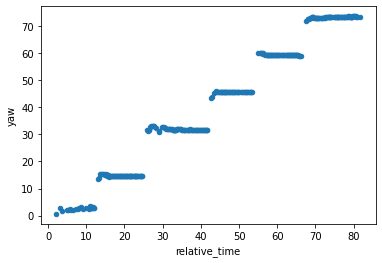

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
17,2.104857,0.571735,0
24,3.124393,2.802484,0
28,3.668520,1.533002,0
37,4.887732,1.908941,0
40,5.322673,2.099436,0
...,...,...,...
1522,80.291246,73.612929,75
1527,80.499120,73.579677,75
1529,80.588542,73.625570,75
1537,80.930930,73.549402,75


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
17,2.104857,0.571735,0,-0.571735
24,3.124393,2.802484,0,-2.802484
131,13.186135,13.552831,10,-3.552831
134,13.316461,13.860798,10,-3.860798
410,25.940951,31.741412,30,-1.741412
413,26.097061,31.226275,30,-1.226275
724,42.775545,43.622212,45,1.377788
729,43.018738,43.992768,45,1.007232
959,55.055358,60.027091,60,-0.027091
966,55.417892,60.165602,60,-0.165602


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,25.0,-2.542612,0.600477,-3.368735,-2.879072,-2.679309,-2.284866,-0.571735
10,70.0,-4.666387,0.297029,-5.508989,-4.715612,-4.649007,-4.528730,-3.552831
30,77.0,-1.916499,0.437517,-3.249492,-1.886539,-1.762159,-1.714070,-1.019112
45,50.0,-0.599401,0.384474,-1.144377,-0.732132,-0.641507,-0.616787,1.377788
60,63.0,0.623320,0.256418,-0.165602,0.662953,0.698370,0.733558,0.860587
75,76.0,1.682612,0.300493,1.355481,1.476421,1.562790,1.848578,2.935473


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

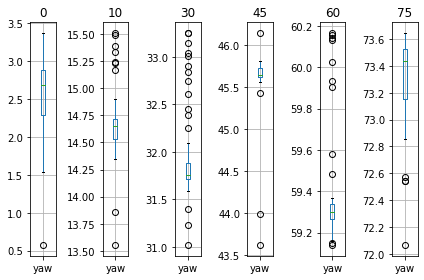

In [16]:
box_plotter(target)

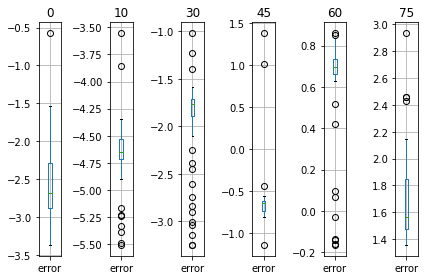

In [17]:
box_plotter('error')